In [159]:
# Import necessary libraries
import pandas as pd
import numpy as np
# For text analysis
from nltk.tokenize import sent_tokenize, word_tokenize   
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Word embeddings
import gensim 
from gensim.models import Word2Vec
# Statistics and model related
from statistics import mode, StatisticsError
import random 
from sklearn import preprocessing, neighbors
from sklearn.utils import resample
# Model development
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import pickle
# EDA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristenboyle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Read tips dataset
df_tip = pd.read_csv('/Users/kristenboyle/Downloads/yelp_dataset/tip.csv')
# Load ratings, stars, etc. for businesses
df_business = pd.read_csv('/Users/kristenboyle/Downloads/yelp_dataset/business.csv')
# Food inspection data
df_inspection = pd.read_csv('/Users/kristenboyle/Downloads/restaurant-inspections-1.csv')

/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,32,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
# Functions
def pick_one(input_list):
    x = random.choice(input_list)
    return x

# Find the length of a list in the df row
def get_len(x):
    y = len(x)
    return y

# The below function removes the stop words and tokenize a sentence
def preprocess(text):
    tokens = gensim.utils.simple_preprocess(text)
    stop_words = stopwords.words('english')
    return [tok for tok in tokens if tok not in stop_words]

# Finds the mode in the list, if there is tie pick random
def find_mode(input_list):
    try: 
        x = mode(input_list)
    except StatisticsError: # If the list is bimodal, then take a random element. Justification: add noise
        x = random.choice(input_list)
    return x

# Find the number of negative words based on the length of each row from 'negative_word'
def freq_finder(x):
    y = len(x)
    return y

# Enode 2017 into: 0 for A; 1 for B, C and X
def label_to_numeric(x):
    if x == "A":
        y = 0
    else:
        y = 1
    return y

# Change label from A to Good and B,C,X to bad
def label_to_label(x):
    if x == "A":
        y = 'Good'
    else:
        y = 'Bad'
    return y

In [5]:
# Combine all the tips for each business
df_tip2 = df_tip.groupby('business_id').agg(lambda x: x.tolist()) 
# Convert each row (list of tips) for "text" column to a single string separated by ";"
df_tip2['text_all'] = df_tip2['text'].str.join(';')
# count the number of tips for each business
df_tip2['tips_count'] = df_tip2['compliment_count'].apply(get_len)
df_tip2.head(3)

,compliment_count,date,user_id,text,text_all,tips_count
business_id,,,,,,
--1UhMGODdWsrMastO9DZw,[0],[2017-07-26 17:26:25],[4YHZzwlxEMi7zWO6Osszdw],"[Delicious! One of the best burritos, salsa an...","Delicious! One of the best burritos, salsa and...",1
--6MefnULPED_I942VcFNA,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2013-03-24 01:12:20, 2014-07-11 15:48:40, 201...","[EiP1OFgs-XGcKZux0OKWIA, 2oMkzQcRL7-d7URt3Xo_X...","[BBQ pork is sold out early on Saturday, $5 lu...",BBQ pork is sold out early on Saturday;$5 lunc...,14
--7zmmkVg-IMGaXbuVd0SQ,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2017-08-17 20:35:18, 2015-02-27 23:35:49, 201...","[Z7pFsGpIyLzMTZsXjTFF1A, Zqhl8pDShvMr2Vt1mIGC4...","[Good place to stop when traffic don't go., Fl...",Good place to stop when traffic don't go.;Flig...,11


In [6]:
# Clean and tokenize
df_tip2 = df_tip2.dropna() # Remove NaNs
desired_series = df_tip2.text_all.tolist()
series_token = [preprocess(sentence) for sentence in desired_series] # Function: preprocess
df_tip2['text_clean'] = series_token # Create a series with tokens
df_tip2['text_clean'].head(3)

business_id
--1UhMGODdWsrMastO9DZw    [delicious, one, best, burritos, salsa, vegeta...
--6MefnULPED_I942VcFNA    [bbq, pork, sold, early, saturday, lunch, spec...
--7zmmkVg-IMGaXbuVd0SQ    [good, place, stop, traffic, go, flights, beer...
Name: text_clean, dtype: object

In [14]:
# Not using word2vec anymore
## Word2vec model
#model = Word2Vec(df_tip2['text_clean'], size=50, window=5, min_count=1, workers=4)
#model.save("word2vec.model")
## Predict the similarity between words based on the Word2vec model
#print("Cosine similarity between 'roach' " + "and 'bug': ", 
#      model.similarity('roach', 'clean'))

In [7]:
# df_business: separate businesses in Las Vegas from other cities
df_business1 = df_business[df_business['city'] == "Las Vegas"]
df_business1.columns

Index(['attributes.AgesAllowed', 'hours.Thursday', 'attributes.CoatCheck',
       'attributes.BusinessParking', 'attributes.GoodForMeal',
       'attributes.Alcohol', 'attributes.RestaurantsTableService',
       'attributes.RestaurantsTakeOut', 'attributes.RestaurantsDelivery',
       'attributes.Music', 'hours.Wednesday', 'attributes.Ambience',
       'attributes.HasTV', 'address', 'review_count',
       'attributes.RestaurantsPriceRange2', 'attributes.HairSpecializesIn',
       'attributes.RestaurantsCounterService', 'attributes.BestNights',
       'business_id', 'attributes.DietaryRestrictions',
       'attributes.RestaurantsReservations', 'categories', 'latitude',
       'attributes.Corkage', 'attributes.BusinessAcceptsBitcoin',
       'attributes.OutdoorSeating', 'hours.Tuesday', 'attributes.Smoking',
       'attributes.Caters', 'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsAttire', 'attributes.Open24Hours', 'name',
       'attributes.WheelchairAccessible'

In [8]:
# Create a new df_business with only a subset of features
df_business2 = df_business1.loc[:, ['business_id', 'name', 'stars', 'review_count', 'categories', 
                                    'attributes.RestaurantsPriceRange2', 'address'] ]
df_business2 = df_business2.dropna() # Remove NaNs
df_business2.head(3)

,business_id,name,stars,review_count,categories,attributes.RestaurantsPriceRange2,address
7,gbQN7vr_caG_A1ugSmGhWg,Supercuts,3.5,3,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",3,"4545 E Tropicana Rd Ste 8, Tropicana"
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,4.0,40,"Restaurants, Italian",2,"1775 E Tropicana Ave, Ste 29"
22,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,4.0,107,"Nightlife, Arts & Entertainment, Bars, Strip C...",2,6007 Dean Martin Dr


In [10]:
# Includes businesses if "Restaurants" exist in the "categories" column
df_business3 = df_business2[df_business2['categories'].str.contains('Restaurants')]
# Clean the restaurant names
df_business3.loc[:,'name'] = df_business3['name'].str.lower()
df_business3.head(3)

/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,business_id,name,stars,review_count,categories,attributes.RestaurantsPriceRange2,address
17,PZ-LZzSlhSe9utkQYU8pFg,carluccio's tivoli gardens,4.0,40,"Restaurants, Italian",2,"1775 E Tropicana Ave, Ste 29"
25,tstimHoMcYbkSC4eBA1wEg,maria's mexican restaurant & bakery,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",1,6055 E Lake Mead Blvd
75,kANF0dbeoW34s2vwh6Umfw,dairy queen,2.0,33,"Fast Food, Food, Restaurants, Ice Cream & Froz...",1,6125 Spring Mountain Rd


In [11]:
# Food inspection data
# Separate inspection grade based on year
df_inspection_2017 = df_inspection[df_inspection['Record Updated'].str.contains('2017')]
df_inspection_2016 = df_inspection[df_inspection['Record Updated'].str.contains('2016')]
df_inspection_2015 = df_inspection[df_inspection['Record Updated'].str.contains('2015')]
df_inspection_2014 = df_inspection[df_inspection['Record Updated'].str.contains('2014')]
df_inspection_2013 = df_inspection[df_inspection['Record Updated'].str.contains('2013')]
df_inspection_2012 = df_inspection[df_inspection['Record Updated'].str.contains('2012')]

In [12]:
# Check the number of observations per year
#df_inspection_2017.shape # (18035, 23)
#df_inspection_2016.shape # (19880, 23)
#df_inspection_2015.shape # (21582, 23)
#df_inspection_2014.shape # (20061, 23)
#df_inspection_2013.shape # (68681, 23)
df_inspection_2012.shape # (39, 23)

(39, 23)

In [13]:
# Combine all the inspection throughtout the year
df_inspection_2017vr2 = df_inspection_2017.groupby('Address').agg(lambda x: x.tolist()) 
df_inspection_2016vr2 = df_inspection_2016.groupby('Address').agg(lambda x: x.tolist()) 
df_inspection_2015vr2 = df_inspection_2015.groupby('Address').agg(lambda x: x.tolist()) 
df_inspection_2014vr2 = df_inspection_2014.groupby('Address').agg(lambda x: x.tolist()) 
df_inspection_2013vr2 = df_inspection_2013.groupby('Address').agg(lambda x: x.tolist()) 

In [14]:
# Find mode for each 
df_inspection_2017vr2['mode'] = df_inspection_2017vr2['Inspection Grade'].apply(find_mode)
df_inspection_2016vr2['mode'] = df_inspection_2016vr2['Inspection Grade'].apply(find_mode)
df_inspection_2015vr2['mode'] = df_inspection_2015vr2['Inspection Grade'].apply(find_mode)
df_inspection_2014vr2['mode'] = df_inspection_2014vr2['Inspection Grade'].apply(find_mode)
df_inspection_2013vr2['mode'] = df_inspection_2013vr2['Inspection Grade'].apply(find_mode)

In [15]:
# Index is based on address, make it a column too
df_inspection_2017vr2['address'] = df_inspection_2017vr2.index
df_inspection_2016vr2['address'] = df_inspection_2016vr2.index
df_inspection_2015vr2['address'] = df_inspection_2015vr2.index
df_inspection_2014vr2['address'] = df_inspection_2014vr2.index
df_inspection_2013vr2['address'] = df_inspection_2013vr2.index
df_inspection_2017vr2.columns

Index(['Serial Number', 'Permit Number', 'Restaurant Name', 'Location Name',
       'Category Name', 'City', 'State', 'Zip', 'Current Demerits',
       'Current Grade', 'Date Current', 'Inspection Date', 'Inspection Time',
       'Employee ID', 'Inspection Type', 'Inspection Demerits',
       'Inspection Grade', 'Permit Status', 'Inspection Result', 'Violations',
       'Record Updated', 'Location 1', 'mode', 'address'],
      dtype='object')

In [16]:
# Take a  subset of columns 
df_inspection_2017vr3 = df_inspection_2017vr2.loc[:, ['Restaurant Name', 'mode', 'address']]
df_inspection_2016vr3 = df_inspection_2016vr2.loc[:, ['Restaurant Name', 'mode', 'address']]
df_inspection_2015vr3 = df_inspection_2015vr2.loc[:, ['Restaurant Name', 'mode', 'address']]
df_inspection_2014vr3 = df_inspection_2014vr2.loc[:, ['Restaurant Name', 'mode', 'address']]
df_inspection_2013vr3 = df_inspection_2013vr2.loc[:, ['Restaurant Name', 'mode', 'address']]

# "Restaurant Name" is a list, pick one name (the list presumably is made of the same name)
df_inspection_2017vr3['Restaurant Name'] = df_inspection_2017vr3['Restaurant Name'].apply(pick_one)
df_inspection_2016vr3['Restaurant Name'] = df_inspection_2016vr3['Restaurant Name'].apply(pick_one)
df_inspection_2015vr3['Restaurant Name'] = df_inspection_2015vr3['Restaurant Name'].apply(pick_one)
df_inspection_2014vr3['Restaurant Name'] = df_inspection_2014vr3['Restaurant Name'].apply(pick_one)
df_inspection_2013vr3['Restaurant Name'] = df_inspection_2013vr3['Restaurant Name'].apply(pick_one)

In [18]:
df_inspection_2017vr3.head()

,Restaurant Name,mode,address
Address,,,
#1 Main St,Gold Strike Steakhouse Service Bar,A,#1 Main St
1 Bonnie Springs Rd,BONNIE SPRINGS SALOON SUPP KITCHEN,A,1 Bonnie Springs Rd
1 Cascata Way,Cascata Golf Course Cart #2,A,1 Cascata Way
1 Club Side Dr,Anthem Country Club Clubhouse Restaurant,A,1 Club Side Dr
1 Clubhouse Dr,Tony's Pro Shop 15th Snack Shk Serv,A,1 Clubhouse Dr


In [19]:
# Merge inspection from each year
df_inspection_year = pd.merge(df_inspection_2017vr3, df_inspection_2016vr3, on = 'address')

df_inspection_year = df_inspection_year.drop(columns=['Restaurant Name_y'])
df_inspection_year = df_inspection_year.rename(columns={"Restaurant Name_x": "name", "mode_x": "2017", 
                                                        "mode_y": "2016"})
df_inspection_year_2 = pd.merge(df_inspection_year, df_inspection_2015vr3, on = 'address')

df_inspection_year_2 = df_inspection_year_2.drop(columns=['Restaurant Name'])
df_inspection_year_2 = df_inspection_year_2.rename(columns={"mode": "2015"})

df_inspection_year_3 = pd.merge(df_inspection_year_2, df_inspection_2014vr3, on = 'address')
df_inspection_year_3 = df_inspection_year_3.drop(columns=['Restaurant Name'])
df_inspection_year_3 = df_inspection_year_3.rename(columns={"mode": "2014"})

df_inspection_year_4 = pd.merge(df_inspection_year_3, df_inspection_2013vr3, on = 'address')
df_inspection_year_4 = df_inspection_year_4.drop(columns=['Restaurant Name'])
df_inspection_year_4 = df_inspection_year_4.rename(columns={"mode": "2013"})
df_inspection_year_4.head()

,name,2017,address,2016,2015,2014,2013
0,Gold Strike Steakhouse Service Bar,A,#1 Main St,A,A,A,A
1,BONNIE SPRINGS SALOON SUPP KITCHEN,A,1 Bonnie Springs Rd,A,A,A,A
2,Cascata Golf Course Cart #2,A,1 Cascata Way,A,A,A,A
3,Anthem Country Club Clubhouse Restaurant,A,1 Club Side Dr,A,A,A,A
4,Tony's Pro Shop 15th Snack Shk Serv,A,1 Clubhouse Dr,A,A,A,A


In [20]:
# Join business dataset with df_tip2
df_customer = pd.merge(df_tip2, df_business3, on = 'business_id')
df_customer.columns

Index(['business_id', 'compliment_count', 'date', 'user_id', 'text',
       'text_all', 'tips_count', 'text_clean', 'name', 'stars', 'review_count',
       'categories', 'attributes.RestaurantsPriceRange2', 'address'],
      dtype='object')

In [21]:
# Join df_customer with df_inspection_year_4
df_inspection_year_4['name'] = df_inspection_year_4['name'].str.lower()
df_customer['name'] = df_customer['name'].str.lower()
df_all = pd.merge(df_inspection_year_4, df_customer, on = 'name')

In [25]:
# Number of observations
df_all.dropna()
df_all.shape  

(4042, 20)

In [26]:
df_all.columns

Index(['name', '2017', 'address_x', '2016', '2015', '2014', '2013',
       'business_id', 'compliment_count', 'date', 'user_id', 'text',
       'text_all', 'tips_count', 'text_clean', 'stars', 'review_count',
       'categories', 'attributes.RestaurantsPriceRange2', 'address_y'],
      dtype='object')

In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4042 entries, 0 to 4041
Data columns (total 20 columns):
name                                 4042 non-null object
2017                                 4042 non-null object
address_x                            4042 non-null object
2016                                 4042 non-null object
2015                                 3807 non-null object
2014                                 4041 non-null object
2013                                 4037 non-null object
business_id                          4042 non-null object
compliment_count                     4042 non-null object
date                                 4042 non-null object
user_id                              4042 non-null object
text                                 4042 non-null object
text_all                             4042 non-null object
tips_count                           4042 non-null int64
text_clean                           4042 non-null object
stars                   

In [28]:
# List of health/food saety terms
negative_words = pd.read_csv('/Users/kristenboyle/Documents/food_project/negative_words.csv', header = None)
negative_words_list = negative_words.iloc[:, 0].tolist()
#negative_words_list[0:5]
df_negative = pd.DataFrame({'text_clean': [negative_words_list]})
df_negative

,text_clean
0,"[illness, nausea, vomit, vomitting, diarrhea, ..."


In [29]:
# check if the text_clean column has any of the negative words
def word_finder(x):
    result = [elem for elem in negative_words_list if(elem in x)]
    return result

df_all['negative_word'] = df_all['text_clean'].apply(word_finder)

In [31]:
df_all['negative_word'].tail()

4037    [dirty, sick]
4038       [horrible]
4039               []
4040       [inedible]
4041               []
Name: negative_word, dtype: object

In [34]:
# Find the number of negative words based on the length of each row from 'negative_word' using freq_function
df_all['negative_freq'] = df_all['negative_word'].apply(freq_finder)
df_all.loc[:, ['negative_word', 'negative_freq']].head()

,negative_word,negative_freq
0,[],0
1,"[gross, sick]",2
2,"[roaches, disgusting]",2
3,"[bathroom, toilet, horrible]",3
4,[],0


In [35]:
df_all["2017"].value_counts() # ~90% of the observations belong to label A

A    3616
B     371
C      46
X       9
Name: 2017, dtype: int64

In [38]:
# Enode 2017 and other years into: 0 for A (0- 10 violations); 1 for B (11-20), C (> 20) and X (closed) using label_to_numeric function  
df_all['2017_code'] = df_all['2017'].apply(label_to_numeric)
df_all['2016_code'] = df_all['2016'].apply(label_to_numeric)
df_all['2015_code'] = df_all['2015'].apply(label_to_numeric)
df_all['2014_code'] = df_all['2014'].apply(label_to_numeric)
df_all['2013_code'] = df_all['2013'].apply(label_to_numeric)
df_all['2017_code'].value_counts()

0    3616
1     426
Name: 2017_code, dtype: int64

In [50]:
# Aggregate the number of inspection grade (2013-2016) prior to 2017: 
df_all['aggregate_grade'] = df_all['2013_code'] + df_all['2014_code'] + df_all['2015_code'] + df_all['2016_code']
#df_all.value_counts()
df_all.columns

Index(['name', '2017', 'address_x', '2016', '2015', '2014', '2013',
       'business_id', 'compliment_count', 'date', 'user_id', 'text',
       'text_all', 'tips_count', 'text_clean', 'stars', 'review_count',
       'categories', 'attributes.RestaurantsPriceRange2', 'address_y',
       'negative_word', 'negative_freq', '2017_code', '2016_code', '2015_code',
       '2014_code', '2013_code', 'aggregate_grade'],
      dtype='object')

In [51]:
# Label 2017 grades into good (A) and bad (B, C, X) to be more descriptive in the EDA
df_all['2017_good_bad'] = df_all['2017'].apply(label_to_label)

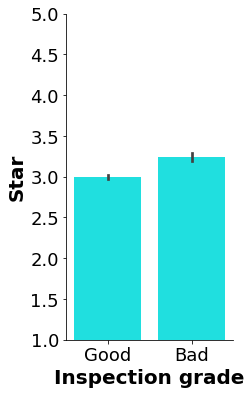

In [226]:
# EDA
# Plot star ratings vs. insepction grade in 2017
fig_star, ax_star = plt.subplots(figsize = (3,6))
ax_star = sns.barplot(x = df_all['2017_good_bad'], y = df_all['stars'], color = 'cyan')
ax_star.tick_params(axis="x", labelsize = 18)
ax_star.tick_params(axis="y", labelsize = 18)
ax_star.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_star.set_ylabel('Star', fontsize = 20, fontweight = 'bold')
ax_star.set_ylim(1, 5) # Min = 1, max = 5
ax_star.spines['right'].set_visible(False) 
ax_star.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/star_grade_vr2.png')

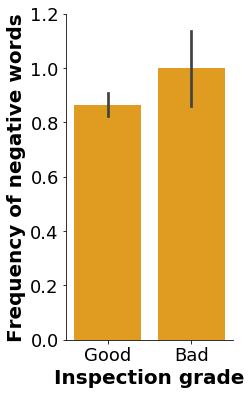

In [230]:
# EDA
# Plot star ratings vs. insepction grade in 2017
fig_freq, ax_freq = plt.subplots(figsize = (3,6))
ax_freq = sns.barplot(x = df_all['2017_good_bad'], y = df_all['negative_freq'], color = 'orange')
ax_freq.tick_params(axis="x", labelsize = 18)
ax_freq.tick_params(axis="y", labelsize = 18)
ax_freq.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_freq.set_ylabel('Frequency of negative words', fontsize = 20, fontweight = 'bold')
ax_freq.set_ylim(0, 1.2)
ax_freq.spines['right'].set_visible(False) 
ax_freq.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/freq_of_negative_words_vs_grade_vr2.png')

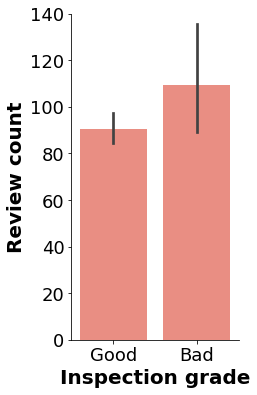

In [236]:
# EDA
# Plot review_count vs. insepction grade in 2017
fig_count, ax_count = plt.subplots(figsize = (3,6))
ax_count = sns.barplot(x = df_all['2017_good_bad'], y = df_all['review_count'], color = 'salmon')
ax_count.tick_params(axis="x", labelsize = 18)
ax_count.tick_params(axis="y", labelsize = 18)
ax_count.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_count.set_ylabel('Review count', fontsize = 20, fontweight = 'bold')
ax_count.set_ylim(0, 140) 
ax_count.spines['right'].set_visible(False) 
ax_count.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/review_count_vs_grade_vr2.png')

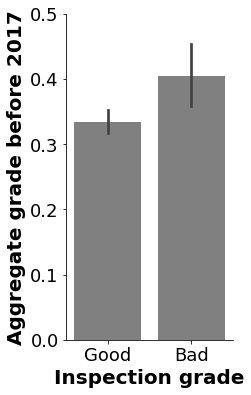

In [225]:
# EDA
# Plot aggregate_grade vs. insepction grade in 2017
fig_aggregate, ax_aggregate = plt.subplots(figsize = (3,6))
ax_aggregate = sns.barplot(x = df_all['2017_good_bad'], y = df_all['aggregate_grade'], color = 'grey')
ax_aggregate.tick_params(axis="x", labelsize = 18)
ax_aggregate.tick_params(axis="y", labelsize = 18)
ax_aggregate.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_aggregate.set_ylabel('Aggregate grade before 2017', fontsize = 20, fontweight = 'bold')
ax_aggregate.set_ylim(0, 0.5)
ax_aggregate.spines['right'].set_visible(False) 
ax_aggregate.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/aggreagte_grade_vs_grade_vr2.png')

In [102]:
# EDA
# Plot price vs. insepction grade in 2017
# Price is based on dollar sign (0-4)
#fig_price, ax_price = plt.subplots(figsize = (7,6))
#ax_price = sns.barplot(x = df_all['2017_good_bad'], y = df_all['attributes.RestaurantsPriceRange2'], color = 'green')
#ax_price.tick_params(axis="x", labelsize = 18)
#ax_price.tick_params(axis="y", labelsize = 18)
#ax_price.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
#ax_price.set_ylabel('Price', fontsize = 20, fontweight = 'bold')
#ax_price.set_ylim(1, 4) 
#ax_price.spines['right'].set_visible(False) 
#ax_price.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/price_vs_grade_vr2.png')
df_all['attributes.RestaurantsPriceRange2'].unique()

array(['1', '2', '3', 'None'], dtype=object)

In [103]:
# Create a dataframe for features/precitors and outcome variable
df_model = df_all.loc[:, ['2017_code', 'aggregate_grade', 'review_count', 'stars', 'negative_freq']]
# Predictors
df_X = df_model.loc[:, [ 'aggregate_grade', 'review_count', 'stars', 'negative_freq']]
df_X = df_model.loc[:, [ 'aggregate_grade', 'review_count', 'stars', 'negative_freq']]
X = df_X.values # df to np array
# Outcome
df_y = df_model.loc[:, '2017_code']
y = df_y.values # df to np array
# For variable that need to be coded
#le = preprocessing.LabelEncoder()
#le.fit(df_X['attributes.RestaurantsPriceRange2'])
#df_X['attributes.RestaurantsPriceRange2'] = le.transform(df_X['attributes.RestaurantsPriceRange2'])

In [134]:
# Model development: Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 27)

model_log = LogisticRegression(C=1e5, solver='lbfgs').fit(X_train, y_train)

y_pred = model_log.predict(X_test) # Predict the test set

model_accuracy_logistic = 100 * accuracy_score(y_test, y_pred) # Mode accuracy: 89.02%
model_accuracy_logistic # 89.5% belongs to label A/0/good

#f1_score(y_test, y_pred)
#np.unique(y_test)
#np.bincount(y_test)

/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [117]:
# Oversampling minority class
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_X, df_y, test_size = 0.25, random_state = 27)
# Concatenate our training data back together
X2 = pd.concat([X_train2, y_train2], axis=1)

# Separate minority and majority classes
good = X2[df_y == 0]
bad = X2[df_y == 1]

# upsample minority
bad_upsampled = resample(bad, replace = True, # sample with replacement
                         n_samples = len(good), # match number in majority class
                         random_state = 27) # reproducible results

# Combine majority and upsampled minority
upsampled = pd.concat([good, bad_upsampled])
upsampled['2017_code'].value_counts()

/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1    2716
0    2716
Name: 2017_code, dtype: int64

In [247]:
# Run the model on the upsample data
model_log2 = LogisticRegression(C=1e5, solver='lbfgs').fit(upsampled.drop('2017_code', axis=1), 
                                                           upsampled['2017_code'])
y_pred2 = model_log2.predict(X_test2) # Predict the test set

model_accuracy_logistic2 = 100 * accuracy_score(y_test2, y_pred2) # Mode accuracy: 89.02%
model_accuracy_logistic2 # 89.5% belongs to label A/0/good
f1_score(y_test2, y_pred2)
# Save
with open('model_logistic.pickle', 'wb') as handle:
    pickle.dump(model_log2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [237]:
# Try random forest
model_rf = RandomForestClassifier(n_estimators = 50).fit(upsampled.drop('2017_code', axis=1), 
                                                           upsampled['2017_code'])
y_pred_rf = model_rf.predict(X_test2)
model_accuracy_rf = 100 * accuracy_score(y_test, y_pred_rf)
model_accuracy_rf
f1_score(y_test2, y_pred_rf)

# Save
with open('model_random_forest.pickle', 'wb') as handle:
    pickle.dump(model_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

0.2411642411642412

In [140]:
# Try knn classifier
model_knn = neighbors.KNeighborsClassifier(10).fit(upsampled.drop('2017_code', axis=1), 
                                                           upsampled['2017_code'])
y_pred_knn = model_knn.predict(X_test)

model_accuracy_knn = 100 * accuracy_score(y_test2, y_pred_knn)
model_accuracy_knn
f1_score(y_test2, y_pred_knn)

0.17037037037037037

('aggregate_grade', 0.06709786636778524)
('review_count', 0.6142211563696061)
('stars', 0.2127578479999796)
('negative_freq', 0.10592312926262906)


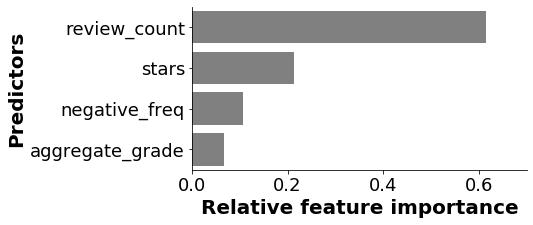

In [234]:
# Check the importance of predictors for the random forest model
X_labels =  [ 'aggregate_grade', 'review_count', 'stars', 'negative_freq']
feat_importance_list = []
for feature in zip(X_labels, model_rf.feature_importances_):
    feat_importance_list.append(feature)
    print(feature)
df_feat_importance = pd.DataFrame(feat_importance_list)

df_feat_importance
df_feat_importance = df_feat_importance.sort_values(by=[1], ascending = False)
# Plot feature importance
fig_feature, ax_feature = plt.subplots(figsize = (6,3))
ax_feature = sns.barplot(y = df_feat_importance.iloc[:,0], x = df_feat_importance.iloc[:,1],  color = 'grey', 
                         orient = 'h')
ax_feature.tick_params(axis="x", labelsize = 18)
ax_feature.tick_params(axis="y", labelsize = 18)
ax_feature.set_xlabel('Relative feature importance', fontsize = 20, fontweight = 'bold')
ax_feature.set_ylabel('Predictors', fontsize = 20, fontweight = 'bold')
#plt.title('Predictors and their relative feature importance', fontsize = 20, fontweight = 'bold')
ax_feature.set_xlim(0, 0.7) 
ax_feature.spines['right'].set_visible(False) 
ax_feature.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/feature_importance_RF.png')

In [173]:
# Check the importance of predictors for the logistic regression (2) model
model_log2.coef_
feat_importance_list

[('aggregate_grade', 0.06709786636778524),
 ('review_count', 0.6142211563696061),
 ('stars', 0.2127578479999796),
 ('negative_freq', 0.10592312926262906)]

In [238]:
upsampled.head()

,aggregate_grade,review_count,stars,negative_freq,2017_code
815,0,38,3.5,0,0
2150,0,40,2.5,0,0
2730,0,12,2.5,0,0
1717,0,24,3.0,0,0
1261,1,86,3.5,0,0


In [240]:
test_app = pd.DataFrame({'aggregate_grade': [4], 'review_count': [1000], "stars" : [4], "negative_freq": [3]})
test_app

,aggregate_grade,review_count,stars,negative_freq
0,4,1000,4,3


In [248]:
model_log2.predict(test_app)

array([1])

In [267]:
## Secondary analysis: Add more features/predictors
# List of potential input features: "fast_food", "tips_count", "attributes.RestaurantsPriceRange2"

def find_fast_food(x): # Find if the restaurant category has "Fast Food" in it

    if 'Fast Food' in x:
        y = 1 # yes
    else: 
        y = 0 # no

     #    y = np.nan
    return y

# Create a 'fast_food' column, yes (1) and no (1)
df_all['fast_food'] = df_all['categories'].apply(find_fast_food)
#df_all['fast_food'].value_counts() # 1 2262, 0 1780

1    2262
0    1780
Name: fast_food, dtype: int64

In [281]:
def find_price(x): # Find the dollar sign (1: $, 2: $$, 3: $$$, 4: $$$$)
    if '1' in x: 
        y = 0 # cheap
    else: 
        y = 1 # expensive
    return y
df_all['price'] =  df_all['attributes.RestaurantsPriceRange2'].apply(find_price)
df_all['price'] =  df_all['price'].astype(int)
df_all['price'].value_counts()

0    3464
1     578
Name: price, dtype: int64

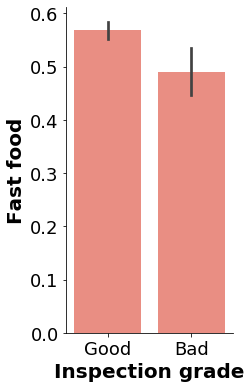

In [283]:
# EDA
# Plot fast_food vs. insepction grade in 2017
fig_fast, ax_fast = plt.subplots(figsize = (3,6))
ax_fast = sns.barplot(x = df_all['2017_good_bad'], y = df_all['fast_food'], color = 'salmon')
ax_fast.tick_params(axis="x", labelsize = 18)
ax_fast.tick_params(axis="y", labelsize = 18)
ax_fast.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_fast.set_ylabel('Fast food', fontsize = 20, fontweight = 'bold')
#ax_fast.set_ylim(0, 140) 
ax_fast.spines['right'].set_visible(False) 
ax_fast.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/fast_food_vs_grade.png')

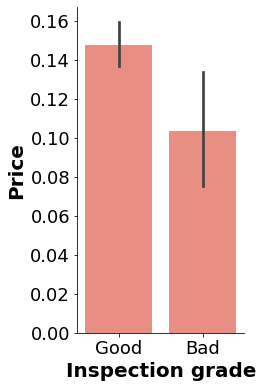

In [284]:
# Plot price vs. insepction grade in 2017
fig_price, ax_price = plt.subplots(figsize = (3,6))
ax_price = sns.barplot(x = df_all['2017_good_bad'], y = df_all['price'], color = 'salmon')
ax_price.tick_params(axis="x", labelsize = 18)
ax_price.tick_params(axis="y", labelsize = 18)
ax_price.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_price.set_ylabel('Price', fontsize = 20, fontweight = 'bold')
#ax_price.set_ylim(0, 140) 
ax_price.spines['right'].set_visible(False) 
ax_price.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/price_vs_grade.png')

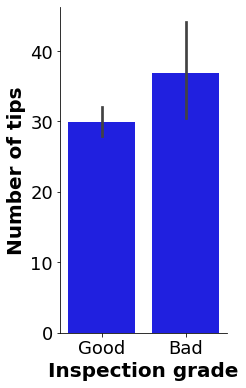

In [285]:
# Plot tips_count vs. insepction grade in 2017
fig_tips_count, ax_price = plt.subplots(figsize = (3,6))
ax_tips_count = sns.barplot(x = df_all['2017_good_bad'], y = df_all['tips_count'], color = 'blue')
ax_tips_count.tick_params(axis="x", labelsize = 18)
ax_tips_count.tick_params(axis="y", labelsize = 18)
ax_tips_count.set_xlabel('Inspection grade', fontsize = 20, fontweight = 'bold')
ax_tips_count.set_ylabel('Number of tips', fontsize = 20, fontweight = 'bold')
#ax_tips_count.set_ylim(0, 140) 
ax_tips_count.spines['right'].set_visible(False) 
ax_tips_count.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/tips_count_vs_grade.png')

In [408]:
# Model development with the additional features
# Create a dataframe for features/precitors and outcome variable

# Predictors
df_all_no_duplicates = df_all.drop_duplicates(subset = 'address_x')
df_predictors = df_all_no_duplicates.loc[:, [ 'aggregate_grade', 'review_count', 'stars', 'negative_freq', 'tips_count',
                               'price', 'fast_food']]

df_response = df_all_no_duplicates['2017_code']

In [450]:
# Oversampling minority class
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_predictors, df_response, test_size = 0.25, 
                                                                    random_state = 27)
# Concatenate our training data back together
predictors_new = pd.concat([X_train_new, y_train_new], axis=1)

# Separate minority and majority classes
good_new = predictors_new[df_response == 0]
bad_new = predictors_new[df_response == 1]

# upsample minority
bad_upsampled_new = resample(bad_new, replace = True, # sample with replacement
                         n_samples = len(good_new), # match number in majority class
                         random_state = 27) # reproducible results

# Combine majority and upsampled minority
upsampled_new = pd.concat([good_new, bad_upsampled_new])
upsampled_new['2017_code'].value_counts()

/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/kristenboyle/anaconda3/envs/food_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


1    365
0    365
Name: 2017_code, dtype: int64

In [459]:
# Try random forest

f1_score_all = []
for i in range(1,30):
    model_rf_new = RandomForestClassifier(n_estimators = 100).fit(upsampled_new.drop('2017_code', axis=1), 
                                                           upsampled_new['2017_code'])
    y_pred_rf_new = model_rf_new.predict(X_test_new)
#model_accuracy_rf_new = 100 * accuracy_score(y_test_new, y_pred_rf_new)
#model_accuracy_rf_new
    f1_score_all.append(f1_score(y_test_new, y_pred_rf_new))

df_f1_score = pd.DataFrame(f1_score_all) 
df_f1_score.mean()
# Save
#with open('model_random_forest_new.pickle', 'wb') as handle:
 #   pickle.dump(model_rf_new, handle, protocol=pickle.HIGHEST_PROTOCOL

0    0.286479
dtype: float64

('aggregate grade', 0.07078581747303157)
('review count', 0.3484934254671919)
('stars', 0.1171989423558344)
('word freq.', 0.09986773668621045)
('tips count', 0.26952108235942396)
('price', 0.06458116035242054)
('fast food', 0.029551835305887172)


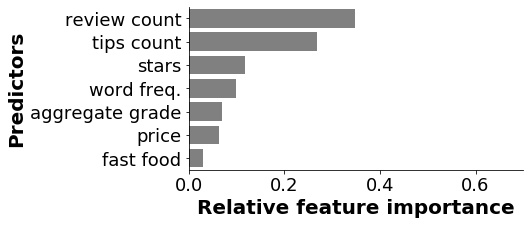

In [462]:
# Check the importance of predictors for the random forest (new) model
X_labels_new =  ['aggregate grade', 'review count', 'stars', 'word freq.', 'tips count', 
                 'price', 'fast food']
feat_importance_list_new = []
for feature in zip(X_labels_new, model_rf_new.feature_importances_):
    feat_importance_list_new.append(feature)
    print(feature)
df_feat_importance_new = pd.DataFrame(feat_importance_list_new)

df_feat_importance_new
df_feat_importance_new = df_feat_importance_new.sort_values(by=[1], ascending = False)
# Plot feature importance
fig_feature_new, ax_feature_new = plt.subplots(figsize = (6,3))
ax_feature_new = sns.barplot(y = df_feat_importance_new.iloc[:,0], x = df_feat_importance_new.iloc[:,1],  
                             color = 'grey', orient = 'h')
ax_feature_new.tick_params(axis="x", labelsize = 18)
ax_feature_new.tick_params(axis="y", labelsize = 18)
ax_feature_new.set_xlabel('Relative feature importance', fontsize = 20, fontweight = 'bold')
ax_feature_new.set_ylabel('Predictors', fontsize = 20, fontweight = 'bold')
#plt.title('Predictors and their relative feature importance', fontsize = 20, fontweight = 'bold')
ax_feature_new.set_xlim(0, 0.7) 
ax_feature_new.spines['right'].set_visible(False) 
ax_feature_new.spines['top'].set_visible(False)
#plt.savefig('/Users/kristenboyle/Documents/food_project/pictures/feature_importance_new_RF.png')

In [449]:
df_all_no_duplicates.shape

(542, 36)

In [456]:
f1_score_all

[0.2777777777777778,
 0.27027027027027023,
 0.25641025641025644,
 0.25641025641025644,
 0.2631578947368421,
 0.25,
 0.3414634146341463,
 0.36842105263157887,
 0.2631578947368421]

In [406]:
#df_all_no_duplicates= df_all.drop_duplicates(subset = 'address_x')
#df_all_no_duplicates['2017_good_bad'].value_counts()

Good    480
Bad      62
Name: 2017_good_bad, dtype: int64

In [ ]:
++++++++